### Importing and Reading HI-Small_Trans.csv

In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv('SAML-D.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [4]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [5]:
df['Payment_currency'].value_counts()

UK pounds          9099293
Euro                117164
Turkish lira         27996
Swiss franc          27492
Dirham               27263
Pakistani rupee      27196
Naira                27143
US dollar            26061
Yen                  25562
Moroccan dirham      25395
Mexican Peso         24852
Albanian lek         24778
Indian rupee         24657
Name: Payment_currency, dtype: int64

In [6]:
df['Is_laundering'].value_counts(normalize=True)


0    0.998961
1    0.001039
Name: Is_laundering, dtype: float64

### Feature Transformation

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
currency_conversion_rates = {
    'US Dollar': 1.0,
    'Euro': 1.03, 
    'Swiss franc': 1.09, 
    'Yuan': 0.14, 
    'Shekel': 0.28,
    'Indian rupee': 0.012, 
    'UK pounds': 1.24, 
    'Yen': 0.0066, 
    'Ruble': 0.01, 
    'Bitcoin': 95781.21,
    'Canadian Dollar': 0.7, 
    'Australian Dollar': 0.63, 
    'Mexican Peso': 0.049, 
    'Saudi Riyal': 0.27, 
    'Brazil Real': 0.17,
    'Turkish lira': 0.028,
    'Dirham': 0.27,
    'Pakistani rupee': 0.0036,
    'Naira': 0.00066,
    'Yen': 0.0065,
    'Moroccan dirham': 0.10,
    'Albanian lek': 0.010,

}

df['Amount (USD)'] = df.apply(lambda row: row['Amount'] * currency_conversion_rates.get(row['Payment_currency'], 1), axis=1)

In [9]:

df['Time'] = pd.to_datetime(df['Date'] +' '+ df['Time'])

df['year'] = df['Time'].dt.year  
df['month'] = df['Time'].dt.month  
df['day'] = df['Time'].dt.day  
df['hour'] = df['Time'].dt.hour
df['min'] = df['Time'].dt.minute
df['second'] = df['Time'].dt.second 

df.drop(columns=['Date', 'Time','Amount'], inplace=True)

cat_col = ['Sender_account', 'Receiver_account', 'Received_currency', 
           'Payment_currency', 'Payment_type', 'Sender_bank_location','Receiver_bank_location','Laundering_type']
for col in cat_col:
    df[col] = LabelEncoder().fit_transform(df[col])


In [10]:
df.head()

,Sender_account,Receiver_account,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,Amount (USD),year,month,day,hour,min,second
0,255277,180462,10,10,16,16,1,0,11,1809.3460,2022,10,7,10,35,19
1,43554,548141,10,1,16,15,5,0,14,7464.3536,2022,10,7,10,35,20
2,8553,287765,10,10,16,16,3,0,20,17767.2656,2022,10,7,10,35,20
3,157249,626370,10,10,16,16,0,0,13,14749.8000,2022,10,7,10,35,21
4,281324,248338,10,10,16,16,1,0,11,142.9100,2022,10,7,10,35,21


### Training a Baseline ML Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [12]:
X =df.drop(columns='Is_laundering')
y = df['Is_laundering']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# Train a Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Model Evaluation
print(classification_report(y_test, y_pred))
y_prob = clf.predict_proba(X_test)[:, 1]  
print(f'AUC-ROC Score: {roc_auc_score(y_test, y_prob):.4f}')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1898996
           1       1.00      1.00      1.00      1975

    accuracy                           1.00   1900971
   macro avg       1.00      1.00      1.00   1900971
weighted avg       1.00      1.00      1.00   1900971

AUC-ROC Score: 1.0000


### Adding Contextual Feature - this will help us to identify the FAN-OUT Money Laundering Pattern

In [14]:
import networkx as nx

G = nx.DiGraph()

for _, row in df.iterrows():
    G.add_edge(row['Sender_account'], row['Receiver_account'], weight=row['Amount (USD)'])

df['degree_centrality'] = df['Sender_account'].map(nx.degree_centrality(G))
df['pagerank'] = df['Sender_account'].map(nx.pagerank(G))


In [15]:
X =df.drop(columns='Is_laundering')
y = df['Is_laundering']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
y_prob = clf.predict_proba(X_test)[:, 1]  
print(f'AUC-ROC Score: {roc_auc_score(y_test, y_prob):.4f}')



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1898996
           1       1.00      1.00      1.00      1975

    accuracy                           1.00   1900971
   macro avg       1.00      1.00      1.00   1900971
weighted avg       1.00      1.00      1.00   1900971

AUC-ROC Score: 1.0000


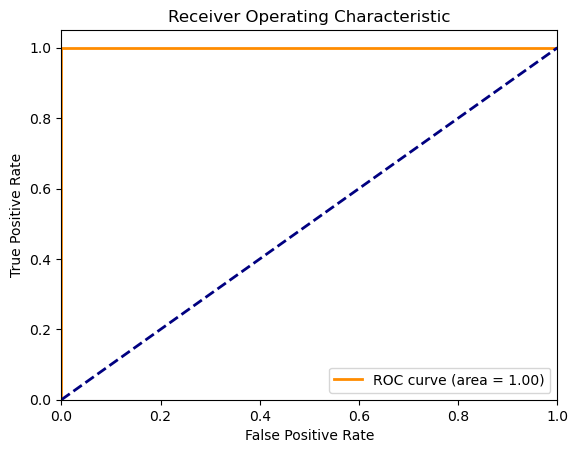

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have your model predictions (y_pred_proba) and true labels (y_true) 

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob) 

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_prob) 

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()